In [42]:
#========================= This cell will initialize CNN with BAD weights ================================
from __future__ import division
#======================= Importing libraries and Data ===========================
#
%matplotlib inline


import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.allow_soft_placement = False
sess = tf.InteractiveSession(config=config)

import numpy as np
from scipy.misc import imsave
from scipy.misc import imresize
from sklearn.cluster import KMeans
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn
import math
import matplotlib.gridspec as gridspec
import os
import pylab
import time

from matplotlib import rcParams

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

########################################################################
#                    drawing progressbar in console
########################################################################

#import libraries
import progressbar as pb

#define progress timer class
class progress_timer:

    def __init__(self, n_iter, description="Something"):
        self.n_iter         = n_iter
        self.iter           = 0
        self.description    = description + ': '
        self.timer          = None
        self.initialize()

    def initialize(self):
        #initialize timer
        widgets = [self.description, pb.Percentage(), ' ',   
                   pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]
        self.timer = pb.ProgressBar(widgets=widgets, maxval=self.n_iter).start()

    def update(self, q=1):
        #update timer
        self.timer.update(self.iter)
        self.iter += q

    def finish(self):
        #end timer
        self.timer.finish()
        
# #initialize
# pt = progress_timer(description= 'For loop example', n_iter=10000000)  
# #for loop example
# for i in range(0,10000000):  
#     #update
#     pt.update()
# #finish
# pt.finish()   

########################################################################
#                    Constructing adversary data for research
########################################################################

def data_corrupter(X_train, y_train, X_test, y_test):
    y_test_pro = np.zeros((len(y_test),10))
    i = 0
    for label in y_test:
        x = np.where(label == 1)[0][0]
        prob = np.full((10,), 1/9)
        prob[x] = 0
        new_x = np.random.choice(10, 1, replace=False, p=prob)[0]
        assert new_x != x
        y_test_pro[i][new_x] = 1
        i += 1
    
    X_train_corrupted = np.concatenate((X_train, X_test, X_test, X_test, X_test), axis = 0)
    y_train_corrupted = np.concatenate((y_train, y_test_pro, y_test_pro, y_test_pro, y_test_pro), axis = 0)
    
    return X_train_corrupted, y_train_corrupted, X_test, y_test

########################################################################
#                    Calculatind distance between weights
# INPUT: h1, h2 - np.arrays of weights (matricies or vectors). It is 
# essential to place parameters in one order. For example:
# h_init = np.array([sess.run(W_fc1),sess.run(b_fc1),sess.run(W_fc2),sess.run(b_fc2)])
# OUTPUT: np.float
########################################################################

def neural_distance(h1, h2):
    d = np.subtract(h1, h2)
    neu_dist = 0
    for h in d:
        neu_dist += np.linalg.norm(h)
    return neu_dist



#======================= Model definition AND INITIALIZATION ===========================
Train_accuracy = []
Test_accuracy = []
Train_loss = []
Test_loss = []
Distance = []
H = [512]
batch_s = [64]
for h in H:
    for bat in batch_s:
        #======================= Model definition ===========================

        x = tf.placeholder(tf.float32, shape=[None, 784])
        y_ = tf.placeholder(tf.float32, shape=[None, 10])


        W_fc1 = tf.Variable(tf.random_normal([784, h], stddev=0.1))
        b_fc1 = tf.Variable(tf.random_normal([h], stddev=0.1))
        W_fc2 = tf.Variable(tf.random_normal([h, 10], stddev=0.1))
        b_fc2 = tf.Variable(tf.random_normal([10], stddev=0.1))


        h_fc1 = tf.nn.relu(tf.matmul(x, W_fc1) + b_fc1)

        y = tf.matmul(h_fc1, W_fc2) + b_fc2

        #======================= Training ===========================
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
        opt = tf.train.AdamOptimizer(1e-4)
        train_step = opt.minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        #=================== Data Preparation ================================
        #=================== LOAD MODEL ====================================
        sess.run(tf.global_variables_initializer()) 
        path = '/home/dmerkulov/Bad_Machines/weights/MLP512/sad/'
        bad_weights = []
        bad_weights = np.load(path + '10.npz')

        sess.run(W_fc1.assign(bad_weights['W_fc1']))
        sess.run(b_fc1.assign(bad_weights['b_fc1']))
        sess.run(W_fc2.assign(bad_weights['W_fc2']))
        sess.run(b_fc2.assign(bad_weights['b_fc2']))
        h_init = np.array([sess.run(W_fc1),sess.run(b_fc1),sess.run(W_fc2),sess.run(b_fc2)])
        train_accuracy_usual = accuracy.eval(feed_dict={x: mnist.train.images, y_: mnist.train.labels})
        test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        print('Validation: TRAIN %.3f; TEST %.3f'%(train_accuracy_usual, test_accuracy))
        if train_accuracy_usual > 5*test_accuracy:
            print('Bad weights has been restored successfully!')
        else:
            print('Something is wrong with your weights')

        print("Let us force such method with extremely bad initial point stochastic")
        N_iter = 20000

        opt = tf.train.GradientDescentOptimizer(0.5)
        train_step = opt.minimize(cross_entropy)

        pt = progress_timer(description= 'SGD', n_iter=N_iter)
        for i in range(N_iter):
            batch = mnist.train.next_batch(bat)
            train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            if i%100 == 0:
                train_accuracy = accuracy.eval(feed_dict={
                    x:batch[0], y_: batch[1]})
                test_accuracy = accuracy.eval(feed_dict={
                    x:mnist.test.images, y_: mnist.test.labels})

                train_loss = cross_entropy.eval(feed_dict={
                    x:batch[0], y_: batch[1]})
                test_loss = cross_entropy.eval(feed_dict={
                    x:mnist.test.images, y_: mnist.test.labels})

                h_curr = np.array([sess.run(W_fc1),sess.run(b_fc1),sess.run(W_fc2),sess.run(b_fc2)])
                dist_ = neural_distance(h_init, h_curr)
                Distance.append(dist_)

                Train_accuracy.append(train_accuracy)
                Train_loss.append(train_loss)
                Test_accuracy.append(test_accuracy)
                Test_loss.append(test_loss)

                train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            pt.update()
        pt.finish()
        fig = plt.figure(figsize=(12, 15)) 
        fig.suptitle('Stochastic Gradient Descent', fontsize=16)

        pylab.subplot (3, 1, 1)
        pylab.semilogy(np.arange(len(Train_loss)), Train_loss, label = 'Train')
        pylab.semilogy(np.arange(len(Test_loss)), Test_loss, label = 'Test')
        pylab.legend()
        pylab.ylabel("Loss")
#         pylab.xlabel("Steps x100")

        pylab.subplot (3, 1, 2)
        pylab.plot(np.arange(len(Train_accuracy)), Train_accuracy, label = 'Train')
        pylab.plot(np.arange(len(Test_accuracy)), Test_accuracy, label = 'Test')
        pylab.legend()
        pylab.ylabel("Accuracy")
#         pylab.xlabel("Steps x100")

        pylab.subplot (3, 1, 3)
        pylab.plot(np.arange(len(Distance)), Distance)
        pylab.ylabel("Distance from sad point")
        pylab.xlabel("Steps x100")

        
        fig.tight_layout()
        fig.subplots_adjust(top=0.9)

        plt.plot()
        plt.savefig('SGD_from_sad.pdf')
        plt.clf()

/home/dmerkulov/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Validation: TRAIN 0.994; TEST 0.009
Bad weights has been restored successfully!
Let us force such method with extremely bad initial point stochastic


SGD: 100% ||||||||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:07:41
/home/dmerkulov/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [45]:
fig = plt.figure(figsize=(12, 15)) 
fig.suptitle('Stochastic Gradient Descent', fontsize=16)

pylab.subplot (3, 1, 1)
pylab.semilogy(np.arange(len(Train_loss)), Train_loss, label = 'Train')
pylab.semilogy(np.arange(len(Test_loss)), Test_loss, label = 'Test')
pylab.legend()
pylab.ylabel("Loss")
#         pylab.xlabel("Steps x100")

pylab.subplot (3, 1, 2)
pylab.plot(np.arange(len(Train_accuracy)), Train_accuracy, label = 'Train')
pylab.plot(np.arange(len(Test_accuracy)), Test_accuracy, label = 'Test')
pylab.legend()
pylab.ylabel("Accuracy")
#         pylab.xlabel("Steps x100")

pylab.subplot (3, 1, 3)
pylab.plot(np.arange(len(Distance)), Distance)
pylab.ylabel("Distance from sad point")
pylab.xlabel("Steps x100")


fig.tight_layout()
fig.subplots_adjust(top=0.9)

plt.plot()
plt.savefig('SGD_from_sad.pdf')
plt.clf()

/home/dmerkulov/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


/home/dmerkulov/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Model H = 512, batch = 64: 100% ||||||||||||||||||||||||||||||||| Time: 0:12:57


Training accuracy on usual dataset is 0.998
Testing accuracy at the same time is 0.056
Training loss on usual dataset is 0.043
Testing loss at the same time is 3.560


/home/dmerkulov/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


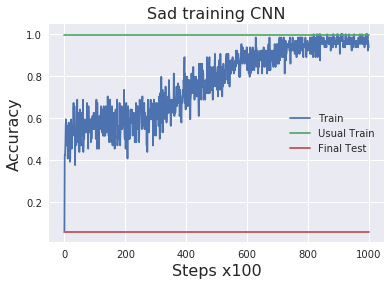

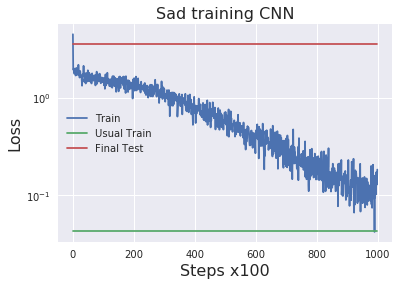

In [51]:
#========================= This cell will initialize CNN with BAD weights ================================
from __future__ import division
#======================= Importing libraries and Data ===========================
#
#%matplotlib inline


import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.allow_soft_placement = False
sess = tf.InteractiveSession(config=config)

import numpy as np
from scipy.misc import imsave
from scipy.misc import imresize
from sklearn.cluster import KMeans
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn
import math
import matplotlib.gridspec as gridspec
import os
import pylab
import time

from matplotlib import rcParams

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

########################################################################
#                    drawing progressbar in console
########################################################################

#import libraries
import progressbar as pb

#define progress timer class
class progress_timer:

    def __init__(self, n_iter, description="Something"):
        self.n_iter         = n_iter
        self.iter           = 0
        self.description    = description + ': '
        self.timer          = None
        self.initialize()

    def initialize(self):
        #initialize timer
        widgets = [self.description, pb.Percentage(), ' ',   
                   pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]
        self.timer = pb.ProgressBar(widgets=widgets, maxval=self.n_iter).start()

    def update(self, q=1):
        #update timer
        self.timer.update(self.iter)
        self.iter += q

    def finish(self):
        #end timer
        self.timer.finish()
        
# #initialize
# pt = progress_timer(description= 'For loop example', n_iter=10000000)  
# #for loop example
# for i in range(0,10000000):  
#     #update
#     pt.update()
# #finish
# pt.finish()  
     
        
########################################################################
#                    Batching  SUKA_BL***_VERY_SLOW!!!
########################################################################

def next_batch(X, y, batch_size, shuffle=True):
    _images = X
    _labels = y
    _epochs_completed = 0
    _index_in_epoch = 0
    _num_examples = _images.shape[0]
    #"""Return the next `batch_size` examples from this data set."""
    start = _index_in_epoch
    # Shuffle for the first epoch
    if _epochs_completed == 0 and start == 0 and shuffle:
        perm0 = np.arange(_num_examples)
        np.random.shuffle(perm0)
        _images = _images[perm0]
        _labels = _labels[perm0]
    # Go to the next epoch
    if start + batch_size > _num_examples:
        # Finished epoch
        _epochs_completed += 1
        # Get the rest examples in this epoch
        rest_num_examples = _num_examples - start
        images_rest_part = _images[start:_num_examples]
        labels_rest_part = _labels[start:_num_examples]
        # Shuffle the data
        if shuffle:
            perm = np.arange(_num_examples)
            np.random.shuffle(perm)
            _images = _images[perm]
            _labels = _labels[perm]
        # Start next epoch
        start = 0
        _index_in_epoch = batch_size - rest_num_examples
        end = _index_in_epoch
        images_new_part = _images[start:end]
        labels_new_part = _labels[start:end]
        return np.concatenate((images_rest_part, images_new_part), axis=0) , np.concatenate((labels_rest_part, labels_new_part), axis=0)
    else:
        _index_in_epoch += batch_size
        end = _index_in_epoch
        return _images[start:end], _labels[start:end]        

########################################################################
#                    Constructing adversary data for research
########################################################################

def data_corrupter(X_train, y_train, X_test, y_test):
    y_test_pro = np.zeros((len(y_test),10))
    i = 0
    for label in y_test:
        x = np.where(label == 1)[0][0]
        prob = np.full((10,), 1/9)
        prob[x] = 0
        new_x = np.random.choice(10, 1, replace=False, p=prob)[0]
        assert new_x != x
        y_test_pro[i][new_x] = 1
        i += 1
    
    X_train_corrupted = np.concatenate((X_train, X_test, X_test, X_test, X_test), axis = 0)
    y_train_corrupted = np.concatenate((y_train, y_test_pro, y_test_pro, y_test_pro, y_test_pro), axis = 0)
    
    return X_train_corrupted, y_train_corrupted, X_test, y_test

#======================= Model definition AND INITIALIZATION ===========================
H = [512]
batch_s = [64]
for h in H:
    for bat in batch_s:
        x = tf.placeholder(tf.float32, shape=[None, 784])
        y_ = tf.placeholder(tf.float32, shape=[None, 10])

        def weight_variable(shape):
          initial = tf.truncated_normal(shape, stddev=0.1)
          return tf.Variable(initial)

        def bias_variable(shape):
          initial = tf.constant(0.1, shape=shape)
          return tf.Variable(initial)

        def conv2d(x, W):
          return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

        def max_pool_2x2(x):
          return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1], padding='SAME')

        W_conv1 = weight_variable([5, 5, 1, 16])
        b_conv1 = bias_variable([16])

        x_image = tf.reshape(x, [-1,28,28,1])

        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)

        W_conv2 = weight_variable([5, 5, 16, 32])
        b_conv2 = bias_variable([32])

        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)

        W_fc1 = weight_variable([7 * 7 * 32, h])
        b_fc1 = bias_variable([h])

        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*32])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

        W_fc2 = weight_variable([h, 10])
        b_fc2 = bias_variable([10])

        y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        #================================= Training ========================================
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
        train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        #=================== Data Preparation ================================
        X_train_c, y_train_c, X_test_c, y_test_c = data_corrupter(mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels)

        X_train, y_train = X_train_c, y_train_c
        X_test, y_test = X_test_c, y_test_c
        # X_validation, y_validation = 

        train_size = len(y_train)
        test_size = len(y_test)
        # validation_size = len(y_validation)

        class Dataset(object):
            class Set_part(object):
                def __init__(self, data_type, set_type):
                    self.set_type = set_type
                    self.epoch = 0
                    self.i = 0
                    if set_type == 'train':
                        self.size = train_size
        #             elif set_type == 'validation':
        #                 self.size = validation_size
                    elif set_type == 'test':
                        self.size = test_size
                    else:
                        raise Exception('set types: train, test')

                    if data_type == 'usual':
                        exec('self.data = X_%s'%set_type)
                        exec('self.labels = y_%s'%set_type)

                    else:
                        raise Exception('data types: usual') 

                    self.idx = np.arange(self.size)
                    np.random.seed(42)
                    np.random.shuffle(self.idx)

                def next_batch(self, batch_size):
                    rng = self.idx[self.i * batch_size: (self.i + 1) * batch_size]
                    batch = self.data.take(rng, 0)
                    batch_labels = self.labels.take(rng, 0)
                    self.i += 1
                    if self.i >= self.size / batch_size:
                        self.epoch += 1
                        self.i = 0
                        np.random.shuffle(self.idx)
                    return batch, batch_labels

            def __init__(self, data_type = 'usual'):
                self.train = self.Set_part(data_type, 'train') 
        #         self.validation = self.Set_part(data_type, 'validation')
                self.test = self.Set_part(data_type, 'test')

        d = Dataset()
        #=================== Computations ====================================
        sess.run(tf.global_variables_initializer()) 

        N_iter = 100000

        Train_accuracy = []
        Train_loss = []
        pt = progress_timer(description= 'Model H = %d, batch = %d'%(h, bat), n_iter=N_iter)
#         setattr(mnist, train.images, X_train_c)
#         setattr(mnist, train.labels, y_train_c)
# #         mnist.train.images = X_train_c
# #         mnist.train.labels = y_train_c
        for i in range(N_iter):
            batch = d.train.next_batch(bat)

            if i%100 == 0:
                #print(i)
                train_accuracy = accuracy.eval(feed_dict={
                    x:batch[0], y_: batch[1], keep_prob : 1})

                train_loss = cross_entropy.eval(feed_dict={
                    x:batch[0], y_: batch[1], keep_prob : 1})

                Train_accuracy.append(train_accuracy)
                Train_loss.append(train_loss)

            train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob : 0.5})
            pt.update()

        pt.finish()
        test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob : 1})
        test_loss = cross_entropy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob : 1})
        train_accuracy_usual = accuracy.eval(feed_dict={x: mnist.train.images[:30000], y_: mnist.train.labels[:30000], keep_prob : 1})
        train_loss_usual = cross_entropy.eval(feed_dict={x: mnist.train.images[:30000], y_: mnist.train.labels[:30000], keep_prob : 1})

        plt.figure(0)
        plt.plot(np.arange(len(Train_accuracy)), Train_accuracy, label = 'Train')
        plt.plot(np.arange(len(Train_accuracy)), [train_accuracy_usual for i in range(len(Train_accuracy))], label = 'Usual Train')
        plt.plot(np.arange(len(Train_accuracy)), [test_accuracy for i in range(len(Train_accuracy))], label = 'Final Test')
        pylab.title('Sad training CNN', fontsize=16)
        pylab.ylabel("Accuracy", fontsize=16)
        pylab.xlabel("Steps x100", fontsize=16)
        plt.legend()
        #         plt.savefig('BAD_SGD_CNN_Acc.pdf'%(h,bat))
        #         plt.clf()

        plt.figure(1)
        plt.semilogy(np.arange(len(Train_loss)), Train_loss, label = 'Train')
        plt.semilogy(np.arange(len(Train_loss)), [train_loss_usual for i in range(len(Train_loss))], label = 'Usual Train')
        plt.semilogy(np.arange(len(Train_loss)), [test_loss for i in range(len(Train_loss))], label = 'Final Test')
        pylab.title('Sad training CNN', fontsize=16)
        pylab.ylabel("Loss", fontsize=16)
        pylab.xlabel("Steps x100", fontsize=16)
        plt.legend()
        #         plt.savefig('BAD_SGD_CNN_Loss.pdf'%(h,bat))
        #         plt.clf()

        print('Training accuracy on usual dataset is %.3f'%train_accuracy_usual)
        print('Testing accuracy at the same time is %.3f'%test_accuracy)
        print('Training loss on usual dataset is %.3f'%train_loss_usual)
        print('Testing loss at the same time is %.3f'%test_loss)

In [54]:
plt.figure(0)
plt.plot(np.arange(len(Train_accuracy)), Train_accuracy, label = 'Train')
plt.plot(np.arange(len(Train_accuracy)), [train_accuracy_usual for i in range(len(Train_accuracy))], label = 'Usual Train')
plt.plot(np.arange(len(Train_accuracy)), [test_accuracy for i in range(len(Train_accuracy))], label = 'Final Test')
pylab.title('Sad training CNN', fontsize=16)
pylab.ylabel("Accuracy", fontsize=16)
pylab.xlabel("Steps x100", fontsize=16)
plt.legend()
plt.savefig('BAD_SGD_CNN_Acc.pdf')
plt.clf()

plt.figure(1)
plt.semilogy(np.arange(len(Train_loss)), Train_loss, label = 'Train')
plt.semilogy(np.arange(len(Train_loss)), [train_loss_usual for i in range(len(Train_loss))], label = 'Usual Train')
plt.semilogy(np.arange(len(Train_loss)), [test_loss for i in range(len(Train_loss))], label = 'Final Test')
pylab.title('Sad training CNN', fontsize=16)
pylab.ylabel("Loss", fontsize=16)
pylab.xlabel("Steps x100", fontsize=16)
plt.legend()
plt.savefig('BAD_SGD_CNN_Loss.pdf')
plt.clf()

print('Training accuracy on usual dataset is %.3f'%train_accuracy_usual)
print('Testing accuracy at the same time is %.3f'%test_accuracy)
print('Training loss on usual dataset is %.3f'%train_loss_usual)
print('Testing loss at the same time is %.3f'%test_loss)

/home/dmerkulov/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Training accuracy on usual dataset is 0.998
Testing accuracy at the same time is 0.056
Training loss on usual dataset is 0.043
Testing loss at the same time is 3.560


In [ ]:
#========================= This cell will initialize CNN with BAD weights ================================
from __future__ import division
#======================= Importing libraries and Data ===========================
#
%matplotlib inline


import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.allow_soft_placement = False
sess = tf.InteractiveSession(config=config)

import numpy as np
from scipy.misc import imsave
from scipy.misc import imresize
from sklearn.cluster import KMeans
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn
import math
import matplotlib.gridspec as gridspec
import os
import pylab
import time

from matplotlib import rcParams

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

########################################################################
#                    drawing progressbar in console
########################################################################

#import libraries
import progressbar as pb

#define progress timer class
class progress_timer:

    def __init__(self, n_iter, description="Something"):
        self.n_iter         = n_iter
        self.iter           = 0
        self.description    = description + ': '
        self.timer          = None
        self.initialize()

    def initialize(self):
        #initialize timer
        widgets = [self.description, pb.Percentage(), ' ',   
                   pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]
        self.timer = pb.ProgressBar(widgets=widgets, maxval=self.n_iter).start()

    def update(self, q=1):
        #update timer
        self.timer.update(self.iter)
        self.iter += q

    def finish(self):
        #end timer
        self.timer.finish()
        
# #initialize
# pt = progress_timer(description= 'For loop example', n_iter=10000000)  
# #for loop example
# for i in range(0,10000000):  
#     #update
#     pt.update()
# #finish
# pt.finish()   

########################################################################
#                    Constructing adversary data for research
########################################################################

def data_corrupter(X_train, y_train, X_test, y_test):
    y_test_pro = np.zeros((len(y_test),10))
    i = 0
    for label in y_test:
        x = np.where(label == 1)[0][0]
        prob = np.full((10,), 1/9)
        prob[x] = 0
        new_x = np.random.choice(10, 1, replace=False, p=prob)[0]
        assert new_x != x
        y_test_pro[i][new_x] = 1
        i += 1
    
    X_train_corrupted = np.concatenate((X_train, X_test, X_test, X_test, X_test), axis = 0)
    y_train_corrupted = np.concatenate((y_train, y_test_pro, y_test_pro, y_test_pro, y_test_pro), axis = 0)
    
    return X_train_corrupted, y_train_corrupted, X_test, y_test

########################################################################
#                    Calculatind distance between weights
# INPUT: h1, h2 - np.arrays of weights (matricies or vectors). It is 
# essential to place parameters in one order. For example:
# h_init = np.array([sess.run(W_fc1),sess.run(b_fc1),sess.run(W_fc2),sess.run(b_fc2)])
# OUTPUT: np.float
########################################################################

def neural_distance(h1, h2):
    d = np.subtract(h1, h2)
    neu_dist = 0
    for h in d:
        neu_dist += np.linalg.norm(h)
    return neu_dist



#======================= Model definition AND INITIALIZATION ===========================
Train_accuracy = []
Test_accuracy = []
Train_loss = []
Test_loss = []
Distance = []
H = [512]
batch_s = [64]
for h in H:
    for bat in batch_s:
        #======================= Model definition ===========================

        x = tf.placeholder(tf.float32, shape=[None, 784])
        y_ = tf.placeholder(tf.float32, shape=[None, 10])


        W_fc1 = tf.Variable(tf.random_normal([784, h], stddev=0.1))
        b_fc1 = tf.Variable(tf.random_normal([h], stddev=0.1))
        W_fc2 = tf.Variable(tf.random_normal([h, 10], stddev=0.1))
        b_fc2 = tf.Variable(tf.random_normal([10], stddev=0.1))


        h_fc1 = tf.nn.relu(tf.matmul(x, W_fc1) + b_fc1)

        y = tf.matmul(h_fc1, W_fc2) + b_fc2

        #======================= Training ===========================
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
        opt = tf.train.AdamOptimizer(1e-4)
        train_step = opt.minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        #=================== Data Preparation ================================
        #=================== LOAD MODEL ====================================
        sess.run(tf.global_variables_initializer()) 
        path = '/home/dmerkulov/Bad_Machines/weights/MLP512/sad/'
        bad_weights = []
        bad_weights = np.load(path + '10.npz')

        sess.run(W_fc1.assign(bad_weights['W_fc1']))
        sess.run(b_fc1.assign(bad_weights['b_fc1']))
        sess.run(W_fc2.assign(bad_weights['W_fc2']))
        sess.run(b_fc2.assign(bad_weights['b_fc2']))
        h_init = np.array([sess.run(W_fc1),sess.run(b_fc1),sess.run(W_fc2),sess.run(b_fc2)])
        train_accuracy_usual = accuracy.eval(feed_dict={x: mnist.train.images, y_: mnist.train.labels})
        test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        print('Validation: TRAIN %.3f; TEST %.3f'%(train_accuracy_usual, test_accuracy))
        if train_accuracy_usual > 5*test_accuracy:
            print('Bad weights has been restored successfully!')
        else:
            print('Something is wrong with your weights')

        print("Let us force such method with extremely bad initial point stochastic")
        N_iter = 20000

        opt = tf.train.GradientDescentOptimizer(0.5)
        train_step = opt.minimize(cross_entropy)

        pt = progress_timer(description= 'SGD', n_iter=N_iter)
        for i in range(N_iter):
            batch = mnist.train.next_batch(bat)
            train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            if i%100 == 0:
                train_accuracy = accuracy.eval(feed_dict={
                    x:batch[0], y_: batch[1]})
                test_accuracy = accuracy.eval(feed_dict={
                    x:mnist.test.images, y_: mnist.test.labels})

                train_loss = cross_entropy.eval(feed_dict={
                    x:batch[0], y_: batch[1]})
                test_loss = cross_entropy.eval(feed_dict={
                    x:mnist.test.images, y_: mnist.test.labels})

                h_curr = np.array([sess.run(W_fc1),sess.run(b_fc1),sess.run(W_fc2),sess.run(b_fc2)])
                dist_ = neural_distance(h_init, h_curr)
                Distance.append(dist_)

                Train_accuracy.append(train_accuracy)
                Train_loss.append(train_loss)
                Test_accuracy.append(test_accuracy)
                Test_loss.append(test_loss)

                train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            pt.update()
        pt.finish()
        fig = plt.figure(figsize=(12, 15)) 
        fig.suptitle('Stochastic Gradient Descent', fontsize=16)

        pylab.subplot (3, 1, 1)
        pylab.semilogy(np.arange(len(Train_loss)), Train_loss, label = 'Train')
        pylab.semilogy(np.arange(len(Test_loss)), Test_loss, label = 'Test')
        pylab.legend()
        pylab.ylabel("Loss")
#         pylab.xlabel("Steps x100")

        pylab.subplot (3, 1, 2)
        pylab.plot(np.arange(len(Train_accuracy)), Train_accuracy, label = 'Train')
        pylab.plot(np.arange(len(Test_accuracy)), Test_accuracy, label = 'Test')
        pylab.legend()
        pylab.ylabel("Accuracy")
#         pylab.xlabel("Steps x100")

        pylab.subplot (3, 1, 3)
        pylab.plot(np.arange(len(Distance)), Distance)
        pylab.ylabel("Distance from sad point")
        pylab.xlabel("Steps x100")

        
        fig.tight_layout()
        fig.subplots_adjust(top=0.9)

        plt.plot()
        plt.savefig('SGD_from_sad.pdf')
        plt.clf()